Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [2]:
##If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

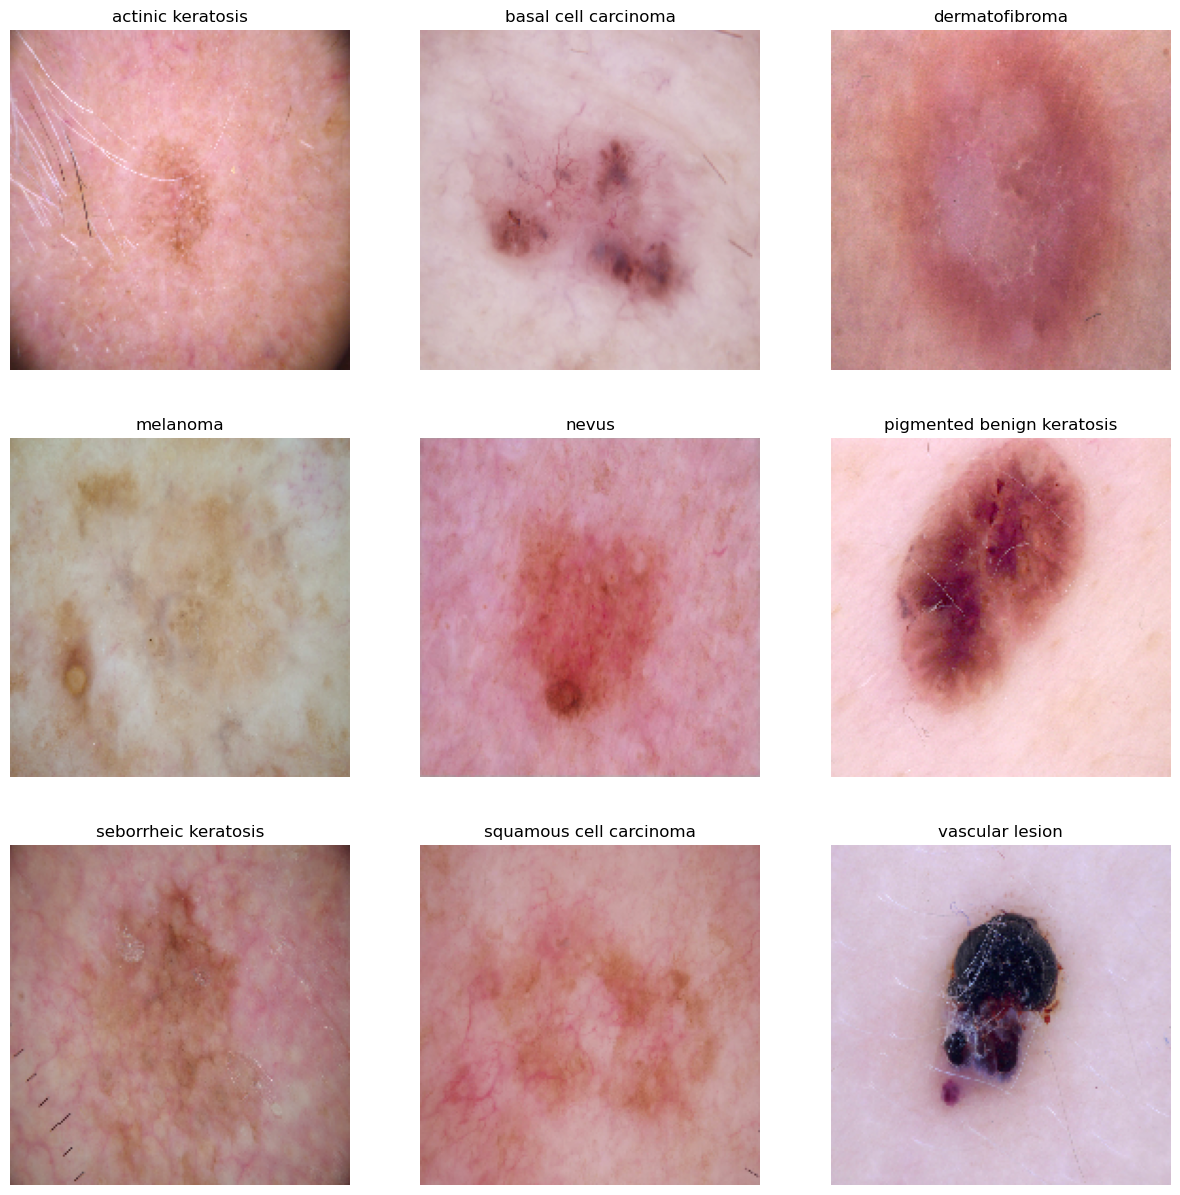

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [23]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [31]:
### Your code goes here

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.45))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(num_classes))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [34]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [36]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [39]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.0815 - loss: 3.3449 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 308ms/step - accuracy: 0.0681 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - accuracy: 0.0690 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.0674 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step - accuracy: 0.0648 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.0546 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.0634 - loss: 2.1972 - val_accuracy: 0.0537 - val_loss: 2.1972
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step - accuracy: 0.0669 - loss: 2.1972 - val_accu

### Visualizing training results

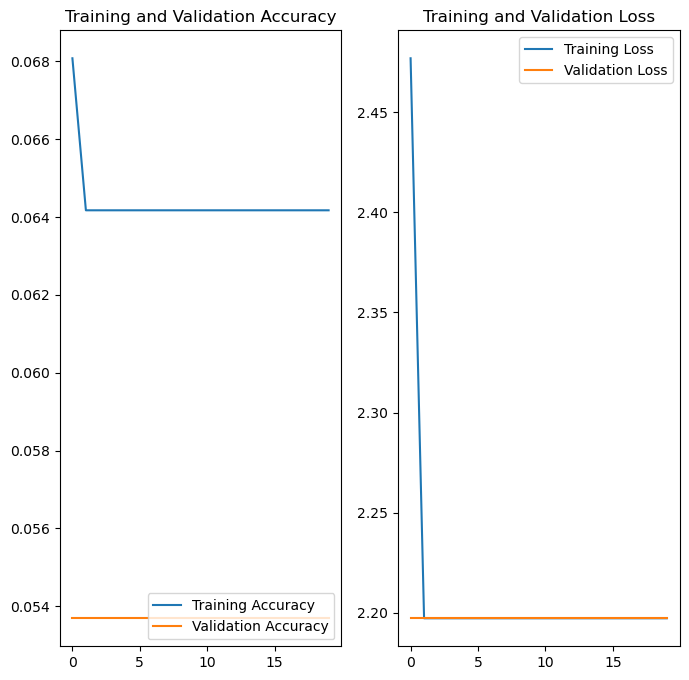

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here>>>> 
### VK >>The model in underfit since both validation & train accuracy are on the lower side.

### This might be because of images being taken from a different angle or the images need to be cropped to get better accuracy.


In [43]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
path_to_training_dataset="/content/gdrive/Othercomputers/My Laptop/UG/CNN/Case study/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2025-03-18 22:31:50.838441: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


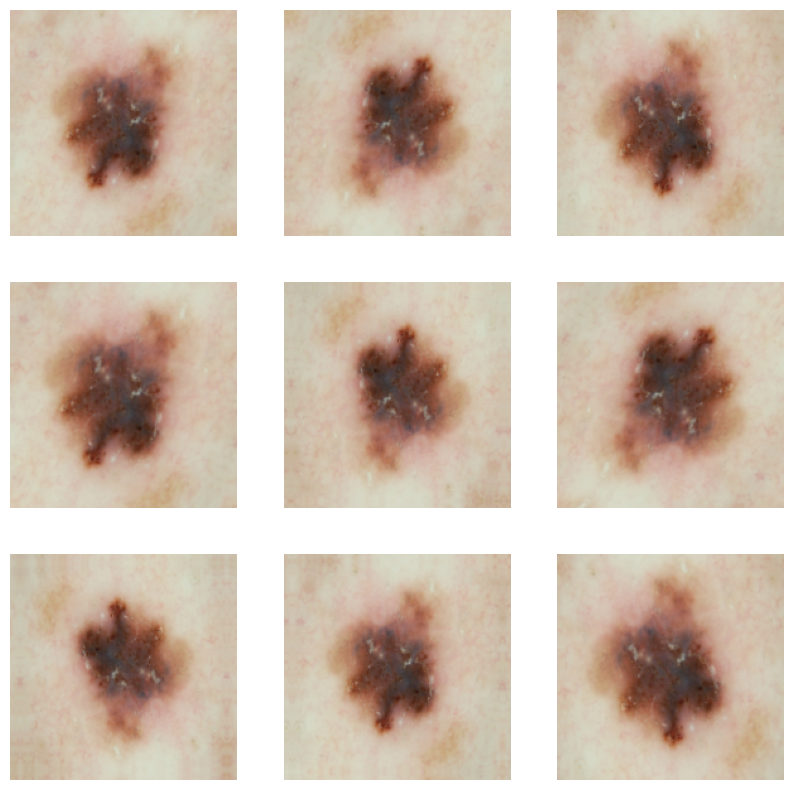

In [45]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [48]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

#Sequential allows you to create models layer-by-layer
model = Sequential([data_augmentation,

layers.Rescaling(1./255,input_shape=(180,180,3)),   #Rescaling Layer

#First Convulation layer
layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),
#Dropout layer with 25% Fraction of the input units to drop.
#layers.Dropout(0.25),

#Second Convulation Layer
layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),
#Dropout layer with 25% Fraction of the input units to drop.
#layers.Dropout(0.25),

#Third Convulation Layer
layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),
#Dropout layer with 25% Fraction of the input units to drop.
#layers.Dropout(0.25),

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
layers.Flatten(),

#Dense Layer
layers.Dense(512,activation='relu'),
#Dropout layer with 25% Fraction of the input units to drop.
#layers.Dropout(0.50),

layers.Dense(len(class_names),activation='softmax'),
])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,168,649 (50.23 MB)

 Trainable params: 13,168,649 (50.23 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [51]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [54]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.1903 - loss: 2.2912 - val_accuracy: 0.3110 - val_loss: 1.9556
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.3425 - loss: 1.7553 - val_accuracy: 0.4340 - val_loss: 1.5900
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.4589 - loss: 1.5528 - val_accuracy: 0.4855 - val_loss: 1.4793
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.5067 - loss: 1.3975 - val_accuracy: 0.5011 - val_loss: 1.4424
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.5193 - loss: 1.3557 - val_accuracy: 0.5391 - val_loss: 1.4261
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.5041 - loss: 1.3911 - val_accuracy: 0.5101 - val_loss: 1.4174
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.5823 - loss: 1.2168 - val_accuracy: 0.5257 - val_loss: 1.3204
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.5459 - loss: 1.2917 - val_accu

### Visualizing the results

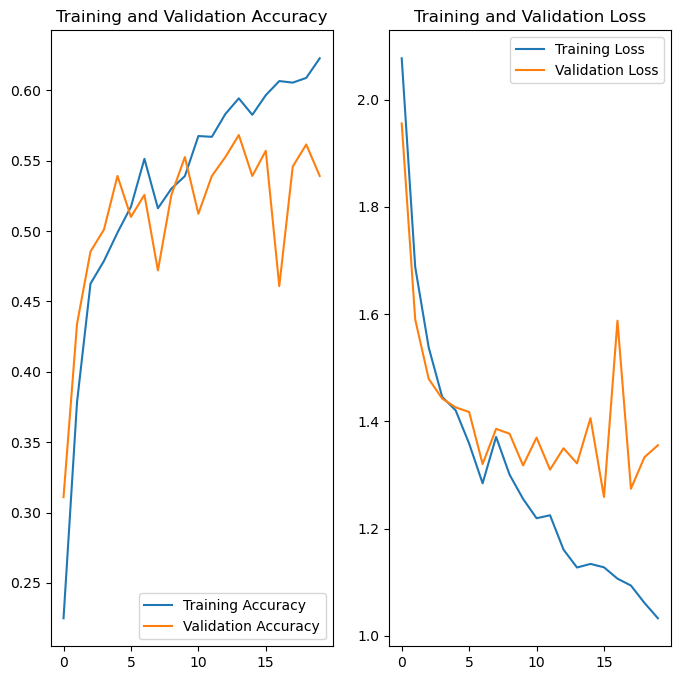

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## VK >>> There is a significant improvement when the images are rotated so the accuracy got increased.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [62]:
## Your code goes here.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
##>>>>>>>> seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##>>>>>>>> pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [64]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
path_to_training_dataset="/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=14, max_right_rotation=14)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17FBD28D0>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1656C8B90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17EEBB860>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x17FC1F5C0>: 100%|█|


Initialised with 357 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17EEBA5D0>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17FC3BEF0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17D4235F0>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BD95010>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17F9AECC0>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [70]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [73]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010791.jpg_8ecf7eec-4090-4122-a393-13675921044d.jpg',
 '/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001112.jpg_7da9a036-0fd8-45f2-abcb-509b71e6081a.jpg',
 '/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010536.jpg_c7f9756c-e188-4dca-8272-038e2ef498c3.jpg',
 '/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010772.jpg_dfedbf54-dcdc-40b4-a46c-c7d70d6c9770.jpg',
 '/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000466.jpg_ec39dd0d-d2b5-4d6c-a314-44e64a941830.jpg',
 '/Users/VKhanna/Downloads/Skin cancer ISIC The Interna

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [77]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [79]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,melanoma
1,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,melanoma
2,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,melanoma
3,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,melanoma
4,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,melanoma
...,...,...
4495,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,dermatofibroma
4496,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,dermatofibroma
4497,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,dermatofibroma
4498,/Users/VKhanna/Downloads/Skin cancer ISIC The ...,dermatofibroma


In [81]:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [85]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [90]:
data_dir_train="/Users/VKhanna/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [220]:
## your code goes here
#Sequential allows you to create models layer-by-layer
model = Sequential([data_augmentation,

layers.Rescaling(1./255,input_shape=(180,180,3)),   #Rescaling Layer
layers.Normalization(),
#First Convulation layer
layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

#Second Convulation Layer
layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

#Third Convulation Layer
layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

#Fourth Convulation Layer
layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),
                    
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
layers.Flatten(),

#Dense Layer
layers.Dense(512,activation='relu'),

layers.Dense(len(class_names),activation='softmax'),
])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 180, 180, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,443,728 (20.77 MB)

 Trainable params: 5,443,721 (20.77 MB)

 Non-trainable params: 7 (32.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [223]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

#### **Todo:**  Train your model

In [226]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step - accuracy: 0.2225 - loss: 2.0273 - val_accuracy: 0.3808 - val_loss: 1.6252
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.3904 - loss: 1.5700 - val_accuracy: 0.4425 - val_loss: 1.4489
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.4416 - loss: 1.4513 - val_accuracy: 0.4165 - val_loss: 1.5069
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - accuracy: 0.4586 - loss: 1.4279 - val_accuracy: 0.4202 - val_loss: 1.4698
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.4721 - loss: 1.3530 - val_accuracy: 0.4878 - val_loss: 1.3146
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accuracy: 0.4999 - loss: 1.2898 - val_accuracy: 0.4885 - val_loss: 1.3468
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 402ms/step - accuracy: 0.4940 - loss: 1.2742 - val_accuracy: 0.4937 - val_loss: 1.3431
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - accuracy: 0.5336 - loss: 1.1922 - val

#### **Todo:**  Visualize the model results

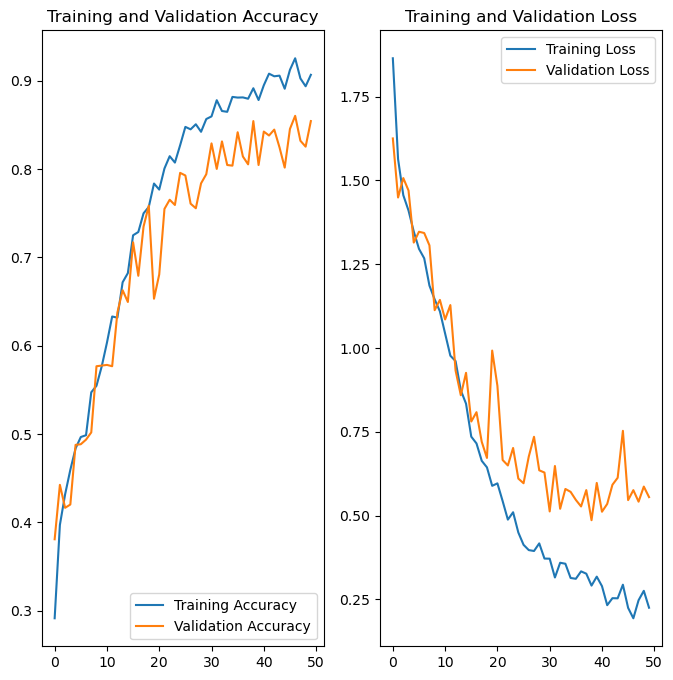

In [238]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
The model gave good accuracy in train of 91% & in validation 86% so which is after rectifying the class imbalance in the dataset
Underfit was resolved using data augmentation. There was a significant improvement when normalization along with data augmentor was used. 

### The model gave good accuracy in train of 91% & in validation 86% so which is after rectifying the class imbalance in the dataset
### Underfit was resolved using data augmentation. There was a significant improvement when normalization along with data augmentor was used. 